In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import glob
import json
import os
from collections import Counter, defaultdict
import subprocess

In [2]:
LIVENESS_FILE = "results_global_liveness_analysis.txt"
CONSTANT_FOLDING_FILE = "results_global_constant_folding.txt"

In [3]:
def parse_results(file_path):
    """Parse the result file into a dictionary."""
    results = {}
    with open(file_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            benchmark = row['benchmark']
            run = row['run']
            result = row['result']
            
            # Convert the result to an integer if possible, or mark as timeout/missing
            if result.isdigit():
                result = int(result)
            else:
                result = result  # Timeout or missing results
            
            if benchmark not in results:
                results[benchmark] = {}
            results[benchmark][run] = result
    return results

def analyze_results(results, analysis_type):
    """Analyze the baseline vs. optimized results and print the comparisons."""
    print(f"\n--- {analysis_type} Analysis ---")
    for benchmark, runs in results.items():
        baseline = runs.get('baseline')
        optimized = runs.get(f'{analysis_type}')
        
        if baseline is not None and isinstance(baseline, int):
            if optimized is not None and isinstance(optimized, int):
                reduction = baseline - optimized
                percentage_reduction = (reduction / baseline) * 100 if baseline != 0 else 0
                print(f"Benchmark: {benchmark}")
                print(f"  Baseline: {baseline}")
                print(f"  {analysis_type}: {optimized}")
                print(f"  Reduction: {reduction} ({percentage_reduction:.2f}%)")
            else:
                print(f"Benchmark: {benchmark} - {analysis_type} result missing or timeout.")
        else:
            print(f"Benchmark: {benchmark} - Baseline result missing or timeout.")

In [4]:
# Parse the results
liveness_results = parse_results(LIVENESS_FILE)
constant_folding_results = parse_results(CONSTANT_FOLDING_FILE)

# Analyze liveness analysis results
analyze_results(liveness_results, 'global_liveness_analysis')

# Analyze constant folding results
analyze_results(constant_folding_results, 'global_constant_folding')


--- global_liveness_analysis Analysis ---
Benchmark: quadratic
  Baseline: 785
  global_liveness_analysis: 783
  Reduction: 2 (0.25%)
Benchmark: primes-between
  Baseline: 574100
  global_liveness_analysis: 573101
  Reduction: 999 (0.17%)
Benchmark: birthday
  Baseline: 484
  global_liveness_analysis: 483
  Reduction: 1 (0.21%)
Benchmark: orders
  Baseline: 5352
  global_liveness_analysis: 5352
  Reduction: 0 (0.00%)
Benchmark: sum-check
  Baseline: 5018
  global_liveness_analysis: 5018
  Reduction: 0 (0.00%)
Benchmark: palindrome
  Baseline: 298
  global_liveness_analysis: 295
  Reduction: 3 (1.01%)
Benchmark: totient
  Baseline: 253
  global_liveness_analysis: 253
  Reduction: 0 (0.00%)
Benchmark: relative-primes
  Baseline: 1923
  global_liveness_analysis: 1914
  Reduction: 9 (0.47%)
Benchmark: hanoi
  Baseline: 99
  global_liveness_analysis: 99
  Reduction: 0 (0.00%)
Benchmark: is-decreasing
  Baseline: 127
  global_liveness_analysis: 127
  Reduction: 0 (0.00%)
Benchmark: check-pr

In [7]:
def calculate_reductions(results, analysis_type):
    """Calculate the percentage reductions for each benchmark."""
    reductions = {}
    for benchmark, runs in results.items():
        baseline = runs.get('baseline')
        optimized = runs.get(analysis_type)
        
        # Ensure the baseline and optimized results are integers
        try:
            baseline = int(baseline) if baseline is not None else None
            optimized = int(optimized) if optimized is not None else None
        except ValueError:
            baseline = None
            optimized = None
        
        if baseline is not None and optimized is not None:
            reduction = baseline - optimized
            percentage_reduction = (reduction / baseline) * 100 if baseline != 0 else 0
            reductions[benchmark] = percentage_reduction
        else:
            reductions[benchmark] = 0  # Missing or timeout
    
    return reductions


def plot_reductions(liveness_reductions, constant_folding_reductions):
    """Create a bar chart comparing liveness and constant folding reductions."""
    # Filter out benchmarks where both liveness and constant folding reductions are 0 or None
    filtered_benchmarks = [
        benchmark for benchmark in liveness_reductions.keys() 
        if liveness_reductions[benchmark] != 0 or constant_folding_reductions[benchmark] != 0
    ]

    # Sort the filtered benchmarks by name
    filtered_benchmarks.sort()

    liveness_vals = [liveness_reductions[b] for b in filtered_benchmarks]
    constant_folding_vals = [constant_folding_reductions[b] for b in filtered_benchmarks]
    
    # Set up the bar chart
    x = np.arange(len(filtered_benchmarks))
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, liveness_vals, width, label='Liveness Analysis')
    rects2 = ax.bar(x + width/2, constant_folding_vals, width, label='Constant Folding')

    # Add some text for labels, title and axes ticks
    ax.set_xlabel('Benchmarks')
    ax.set_ylabel('Reduction (%)')
    ax.set_title('Reduction in Instructions after Optimizations')
    ax.set_xticks(x)
    r = 90
    ax.set_xticklabels(filtered_benchmarks, rotation=r, ha="right")
    ax.legend()

    fig.tight_layout()
    plt.show()

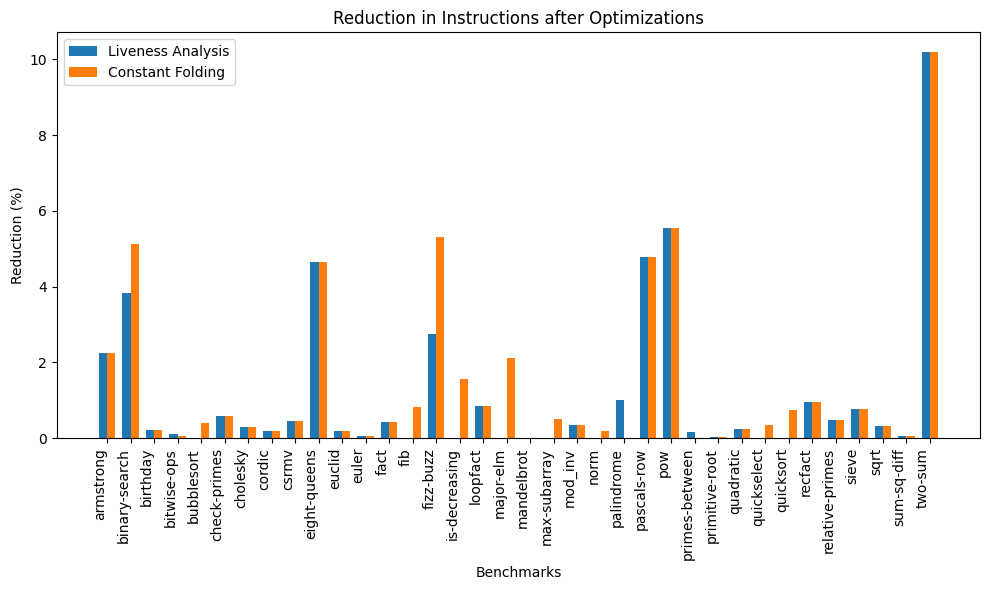

In [8]:
# Parse the results
liveness_results = parse_results(LIVENESS_FILE)
constant_folding_results = parse_results(CONSTANT_FOLDING_FILE)

# Calculate reductions
liveness_reductions = calculate_reductions(liveness_results, 'global_liveness_analysis')
constant_folding_reductions = calculate_reductions(constant_folding_results, 'global_constant_folding')

# Plot the reductions
plot_reductions(liveness_reductions, constant_folding_reductions)